## Chapter 2-6, 1강 NLP 텍스트 분류 — 전통 ML(TF‑IDF) vs 임베딩(SBERT)

- 목표: 전통 특성공학(TF‑IDF+선형모델)과 문장 임베딩(SBERT)+얕은 분류기를 CPU 환경에서 비교
- 데이터: 뉴스 분류(AG News) 또는 영화평(IMDb) 소규모 서브샘플
- 규칙(강의용): matplotlib만 사용, 최소 시각화(혼동행렬), 간결한 데모 셀


### 구성 (Overview)
- 전처리/샘플링 → TF‑IDF+로지스틱 → SBERT 임베딩+로지스틱 → 성능/속도 비교 → 오류사례 확인 → 간단 데모


### 0. 환경 설정 및 라이브러리


In [52]:
# =========================
# 0. 환경 설정 및 라이브러리
# =========================
import os, time, random, math
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
classification_report, confusion_matrix, accuracy_score
)
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", message=".*matmul.*")



# sentence-transformers / datasets 사용 가능 여부 체크
_HAS_SBERT = True
try:
    from sentence_transformers import SentenceTransformer
except Exception:
    _HAS_SBERT = False


_HAS_HF = True
try:
    from datasets import load_dataset
except Exception:
    _HAS_HF = False


# 한글 폰트(맥) 설정 및 마이너스 처리
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False


# 재현성 고정
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)


print("SBERT 사용 가능:", _HAS_SBERT)
print("HuggingFace datasets 사용 가능:", _HAS_HF)


SBERT 사용 가능: True
HuggingFace datasets 사용 가능: True


### 1. 데이터 준비 및 샘플링
- AG News(4클래스) 또는 IMDb(2클래스)에서 소규모 서브샘플
- 실습 편의를 위해 `datasets` 라이브러리를 사용, 없으면 간단 더미 데이터로 대체


In [4]:
# 유틸: 간단 타이머 데코레이터
from contextlib import contextmanager
@contextmanager
def timer(msg: str):
    t0 = time.perf_counter()
    yield
    print(f"[TIME] {msg}: {time.perf_counter()-t0:.2f}s")

In [5]:
# =========================
# 1. 데이터 준비 및 샘플링
# =========================
label_names: List[str] = []


# 옵션: 데이터셋 선택
DATASET = os.environ.get("NLP_DATASET", "ag_news") # "ag_news" or "imdb"
N_PER_CLASS = int(os.environ.get("N_PER_CLASS", 250)) # 클래스당 샘플 수(AG News 기준)
TEST_SIZE = 0.2




def load_ag_news_subset(n_per_class: int = 200) -> Tuple[List[str], List[int]]:
    """AG News 4클래스 균등 샘플링. HF 미사용 시 더미 데이터로 폴백."""
    global label_names
    if not _HAS_HF:
        # 비상용 더미 (2클래스)
        texts = [
        "Stocks rally as market rebounds after selloff",
        "Team wins championship in thrilling final",
        "Government announces new economic policy",
        "Star player transfers to rival club",
        ] * n_per_class
        labels = [0, 1, 0, 1] * n_per_class
        label_names = ["business/politics", "sports"]
        return texts, labels


    ds = load_dataset("ag_news", split="train") # 120k train
    label_names = ["World", "Sports", "Business", "Sci/Tech"]
    xs, ys = [], []
    for lab in range(4):
        sub = ds.filter(lambda ex: ex["label"] == lab).select(range(n_per_class))
        xs += [r["text"] for r in sub]
        ys += [int(r["label"]) for r in sub]
    return xs, ys


In [6]:
def load_imdb_subset(n_total: int = 2000) -> Tuple[List[str], List[int]]:
    """IMDb 2클래스(긍/부정). 총 n_total에서 균등 샘플링. HF 미사용 시 더미로 폴백."""
    global label_names
    label_names = ["neg", "pos"]

    if not _HAS_HF:
        texts = [
            "I loved the film, great performances and story.",
            "Terrible movie with a boring plot.",
        ] * (n_total // 2)
        labels = [1, 0] * (n_total // 2)
        return texts, labels

    ds = load_dataset("imdb")
    # train split에서 균등 샘플링
    train = ds["train"] # 25k
    pos = train.filter(lambda ex: ex["label"] == 1).select(range(n_total // 2))
    neg = train.filter(lambda ex: ex["label"] == 0).select(range(n_total // 2))
    xs = [r["text"] for r in pos] + [r["text"] for r in neg]
    ys = [1] * len(pos) + [0] * len(neg)
    # 셔플
    idx = np.arange(len(xs))
    np.random.shuffle(idx)
    xs = [xs[i] for i in idx]
    ys = [ys[i] for i in idx]
    return xs, ys

In [7]:
# 데이터 로딩
if DATASET == "imdb":
    X_text, y = load_imdb_subset(n_total=2000)
else:
    X_text, y = load_ag_news_subset(n_per_class=N_PER_CLASS)


print(len(X_text), "samples, labels=", sorted(set(y)))
print("label_names:", label_names)


# Train/Val split (stratify 권장)
X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=TEST_SIZE, random_state=42, stratify=y)

Filter: 100%|██████████| 120000/120000 [00:00<00:00, 1244991.58 examples/s]

1000 samples, labels= [0, 1, 2, 3]
label_names: ['World', 'Sports', 'Business', 'Sci/Tech']


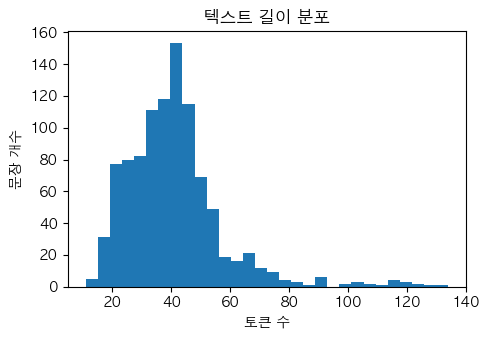


[클래스별 샘플 예시]
[World] Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large number...
[World] S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\central ...
[Sports] Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter frees...
[Sports] Reds Knock Padres Out of Wild-Card Lead (AP) AP - Wily Mo Pena homered twice and drove in four runs, helping the Cincinn...
[Business] Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics,...
[Business] Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputat...
[Sci/Tech] 'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the...
[Sci/Tech] Group to Propose New High-Speed Wireless

In [8]:
# -------------------------
# 1-A. 데이터 탐색(EDA)
# -------------------------
lengths = [len(str(t).split()) for t in X_text]
plt.figure(figsize=(5, 3.5))
plt.hist(lengths, bins=30)
plt.title("텍스트 길이 분포")
plt.xlabel("토큰 수"); plt.ylabel("문장 개수")
plt.tight_layout(); plt.show()


# 클래스별 예시 2개씩 출력
print("\n[클래스별 샘플 예시]")
per_class_shown = {c: 0 for c in set(y)}
for txt, lab in zip(X_text, y):
    if per_class_shown[lab] < 2:
        print(f"[{label_names[lab]}] {str(txt)[:120]}...")
        per_class_shown[lab] += 1

### 2. 전통 파이프라인 — TF‑IDF + 로지스틱 회귀
- 학습/검증 분할, 파이프라인 학습 및 지표 출력


In [9]:
# =========================
# 2. 전통 파이프라인 — TF‑IDF + 로지스틱
# =========================
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
with timer("TF-IDF fit_transform"):
    Xtr = vectorizer.fit_transform(X_train)
with timer("TF-IDF transform(val)"):
    Xva = vectorizer.transform(X_val)


print("TF-IDF 벡터 shape:", Xtr.shape)
print("희소 행렬 밀도:", round(Xtr.nnz / (Xtr.shape[0] * Xtr.shape[1]), 6))


clf_tfidf = LogisticRegression(max_iter=200, n_jobs=None)
with timer("TF-IDF+LR 학습"):
    clf_tfidf.fit(Xtr, y_train)


pred_tfidf = clf_tfidf.predict(Xva)
acc_tfidf = accuracy_score(y_val, pred_tfidf)
print(f"TF-IDF+LR | acc={acc_tfidf:.3f}")
print(classification_report(y_val, pred_tfidf, target_names=label_names))

[TIME] TF-IDF fit_transform: 0.05s
[TIME] TF-IDF transform(val): 0.00s
TF-IDF 벡터 shape: (800, 28755)
희소 행렬 밀도: 0.00247
[TIME] TF-IDF+LR 학습: 0.06s
TF-IDF+LR | acc=0.855
              precision    recall  f1-score   support

       World       0.91      0.78      0.84        50
      Sports       0.80      0.98      0.88        50
    Business       0.88      0.76      0.82        50
    Sci/Tech       0.85      0.90      0.87        50

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



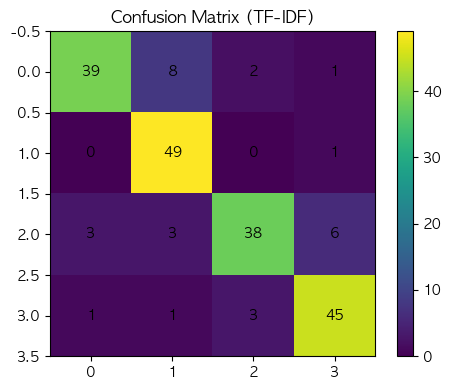

In [10]:
# 혼동행렬(숫자 주석)
cm_tfidf = confusion_matrix(y_val, pred_tfidf)
plt.figure(figsize=(5, 4))
plt.imshow(cm_tfidf)
plt.title("Confusion Matrix (TF-IDF)")
plt.colorbar()
for i in range(cm_tfidf.shape[0]):
    for j in range(cm_tfidf.shape[1]):
        plt.text(j, i, str(cm_tfidf[i, j]), ha='center', va='center')
plt.tight_layout(); plt.show()

In [11]:
# 클래스별 상위 특징 단어 출력
def top_features(clf: LogisticRegression, vectorizer: TfidfVectorizer, n: int = 10):
    names = vectorizer.get_feature_names_out()
    if clf.multi_class in ("ovr", "auto") and clf.coef_.ndim == 2 and clf.coef_.shape[0] > 1:
        for i, lab in enumerate(label_names):
            coef = clf.coef_[i]
            idx = np.argsort(coef)[-n:]
            print(lab, ":", [names[j] for j in idx])
    else:
        coef = clf.coef_[0]
        idx = np.argsort(np.abs(coef))[-n:]
        print("Top features:", [names[j] for j in idx])


print("\n[클래스별 상위 특징 단어 — TF-IDF]")
try:
    top_features(clf_tfidf, vectorizer, n=10)
except Exception as e:
    print("(상위 특징 추출 스킵)", e)


[클래스별 상위 특징 단어 — TF-IDF]
Top features: ['it', 'said', 'chavez', 'bush', 'president', 'najaf', 'troops', 'afp', 'in', 'iraq']


In [33]:
# =========================
# 3. 임베딩 파이프라인 — SBERT + 로지스틱
# =========================

def debug_array(name: str, A: np.ndarray):
    A = np.asarray(A)
    print(f"[{name}] shape={A.shape} dtype={A.dtype} C_CONTIGUOUS={A.flags['C_CONTIGUOUS']} F_CONTIGUOUS={A.flags['F_CONTIGUOUS']}")
    print(f" finite={np.isfinite(A).all()} min={A.min():.6f} max={A.max():.6f} mean_norm={np.mean(np.linalg.norm(A,axis=1)):.6f}")




def sbert_encode(texts: List[str], model_name: str = "sentence-transformers/all-MiniLM-L6-v2", batch_size: int = 64):
    """SBERT 임베딩 with 안전 정규화 및 입력 클린업"""
    if not _HAS_SBERT:
        raise ImportError("sentence-transformers 필요")
    # 입력 클린업: None/빈문장은 대체 토큰으로 치환
    _texts = [t if (isinstance(t, str) and t.strip()) else "[EMPTY]" for t in texts]
    model = SentenceTransformer(model_name, device="cpu") # CPU 고정
    arrs = []
    for i in range(0, len(_texts), batch_size):
        # normalize_embeddings=False로 받고, 수치 안정적인 L2 정규화 수행
        arr = model.encode(
            _texts[i:i+batch_size],
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=False,
        ).astype(np.float64)
        norms = np.linalg.norm(arr, axis=1, keepdims=True)
        arr = arr / np.clip(norms, 1e-12, None)
        # 비정상 값 방지
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        arrs.append(arr)
    out = np.vstack(arrs)
    return out


with timer("SBERT 임베딩 생성(train+val)"):
    if _HAS_SBERT:
        Xtr_emb = sbert_encode(X_train)
        Xva_emb = sbert_encode(X_val)
    else:
        dim = 384
        Xtr_emb = np.random.randn(len(X_train), dim).astype(np.float64)
        Xva_emb = np.random.randn(len(X_val), dim).astype(np.float64)
        print("(주의) SBERT 비활성 — 랜덤 임베딩으로 대체")

[TIME] SBERT 임베딩 생성(train+val): 12.20s


In [ ]:
# 임베딩 수치 안정화(안전망)
Xtr_emb = np.nan_to_num(Xtr_emb, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)
Xva_emb = np.nan_to_num(Xva_emb, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)


# 비정상 행 탐지 로그
_bad_train = np.sum(~np.isfinite(Xtr_emb))
_bad_val = np.sum(~np.isfinite(Xva_emb))
if _bad_train or _bad_val:
    print(f"(주의) 비정상 값 정정 — train:{_bad_train}개, val:{_bad_val}개")


print("SBERT 임베딩 차원:", Xtr_emb.shape[1])

SBERT 임베딩 차원: 384


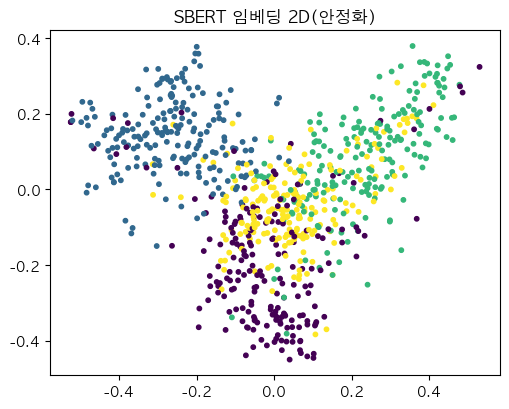

In [29]:
# PCA 2D 투영(일부 샘플) — 수치안정화 옵션
sub_n = min(800, Xtr_emb.shape[0])
idx = np.random.choice(np.arange(Xtr_emb.shape[0]), size=sub_n, replace=False)
X_for_pca = Xtr_emb[idx].astype(np.float64)
try:
    emb2d = PCA(n_components=2, svd_solver='full').fit_transform(X_for_pca)
except Exception as e:
    print("PCA(full) 실패 — TruncatedSVD로 대체:", e)
    from sklearn.decomposition import TruncatedSVD
    emb2d = TruncatedSVD(n_components=2, n_iter=7, random_state=42).fit_transform(X_for_pca)


plt.figure(figsize=(5.2, 4.2))
plt.scatter(emb2d[:, 0], emb2d[:, 1], c=np.array(y_train)[idx], s=10)
plt.title("SBERT 임베딩 2D(안정화)")
plt.tight_layout(); plt.show()

[TIME] SBERT+LR 학습: 0.07s
SBERT+LR | acc=0.870
              precision    recall  f1-score   support

       World       0.83      0.78      0.80        50
      Sports       0.86      0.98      0.92        50
    Business       0.88      0.90      0.89        50
    Sci/Tech       0.91      0.82      0.86        50

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



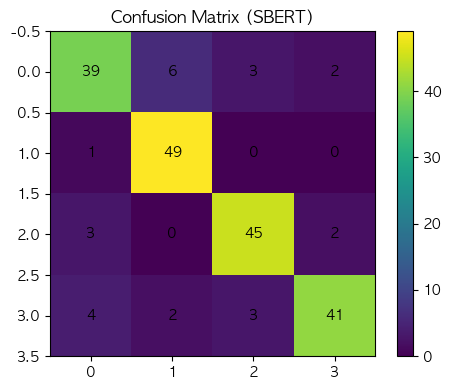

In [53]:
# SBERT 임베딩을 그대로 사용해 로지스틱 회귀 분류기 학습
clf_emb = LogisticRegression(max_iter=200, solver="saga")

with timer("SBERT+LR 학습"):
    clf_emb.fit(Xtr_emb, y_train)

pred_sbert = clf_emb.predict(Xva_emb)
acc_sbert = accuracy_score(y_val, pred_sbert)
print(f"SBERT+LR | acc={acc_sbert:.3f}")
print(classification_report(y_val, pred_sbert, target_names=label_names))

cm_sbert = confusion_matrix(y_val, pred_sbert)
plt.figure(figsize=(5, 4))
plt.imshow(cm_sbert)
plt.title("Confusion Matrix (SBERT)")
plt.colorbar()
for i in range(cm_sbert.shape[0]):
    for j in range(cm_sbert.shape[1]):
        plt.text(j, i, str(cm_sbert[i, j]), ha='center', va='center')
plt.tight_layout(); plt.show()

### 6. 하이퍼파라미터 스윕 (간단)
- TF‑IDF: ngram, C
- SBERT+LR: C (임베딩은 고정)


In [55]:
# 간단 스윕: TF-IDF ngram/C
from sklearn.model_selection import ParameterGrid

params = list(ParameterGrid({
    'ngram_range': [(1,1),(1,2)],
    'C': [0.5, 1.0, 2.0],
}))

best = None
for p in params:
    vec = TfidfVectorizer(max_features=30000, ngram_range=p['ngram_range'])
    Xtr_ = vec.fit_transform(X_train)
    Xva_ = vec.transform(X_val)
    clf_ = LogisticRegression(max_iter=200, C=p['C'])
    clf_.fit(Xtr_, y_train)
    acc_ = accuracy_score(y_val, clf_.predict(Xva_))
    row = (acc_, p)
    if not best or acc_ > best[0]:
        best = row
    print('TF-IDF', p, 'acc=', round(acc_,3))

print('Best TF-IDF:', best)

# SBERT+LR: C만 스윕(임베딩 재사용)
for C in [0.5, 1.0, 2.0]:
    clf_ = LogisticRegression(max_iter=200, C=C)
    clf_.fit(Xtr_emb, y_train)
    acc_ = accuracy_score(y_val, clf_.predict(Xva_emb))
    print('SBERT+LR', {'C': C}, 'acc=', round(acc_,3))


TF-IDF {'C': 0.5, 'ngram_range': (1, 1)} acc= 0.865
TF-IDF {'C': 0.5, 'ngram_range': (1, 2)} acc= 0.84
TF-IDF {'C': 1.0, 'ngram_range': (1, 1)} acc= 0.875
TF-IDF {'C': 1.0, 'ngram_range': (1, 2)} acc= 0.855
TF-IDF {'C': 2.0, 'ngram_range': (1, 1)} acc= 0.89
TF-IDF {'C': 2.0, 'ngram_range': (1, 2)} acc= 0.87
Best TF-IDF: (0.89, {'C': 2.0, 'ngram_range': (1, 1)})
SBERT+LR {'C': 0.5} acc= 0.87
SBERT+LR {'C': 1.0} acc= 0.87
SBERT+LR {'C': 2.0} acc= 0.86


### 7. 모델/벡터라이저 저장 & 로딩 (joblib)
- 추론 재현을 위한 간단 저장/불러오기


In [56]:
import joblib, os
os.makedirs('./artifacts', exist_ok=True)

# 저장
joblib.dump(vectorizer, './artifacts/tfidf_vectorizer.joblib')
joblib.dump(clf_tfidf, './artifacts/tfidf_lr.joblib')
joblib.dump(clf_emb, './artifacts/sbert_lr.joblib')

# 로딩 & 간단 검증
vec2 = joblib.load('./artifacts/tfidf_vectorizer.joblib')
clf2 = joblib.load('./artifacts/tfidf_lr.joblib')
acc_check = accuracy_score(y_val, clf2.predict(vec2.transform(X_val)))
print('Reloaded TF-IDF acc=', round(acc_check,3))


Reloaded TF-IDF acc= 0.855


### 8. 추론 속도 비교 (샘플 N개)
- TF‑IDF vs SBERT 파이프라인


In [57]:
def bench_inference(n=128):
    samp = X_val[:n]
    t0 = time.perf_counter(); _ = clf_tfidf.predict(vectorizer.transform(samp)); t_tfidf = time.perf_counter()-t0
    t0 = time.perf_counter(); _ = clf_emb.predict(sbert_encode(samp)); t_sbert = time.perf_counter()-t0
    print({'n': n, 'tfidf_sec': round(t_tfidf,3), 'sbert_sec': round(t_sbert,3)})

bench_inference(64)
bench_inference(128)


{'n': 64, 'tfidf_sec': 0.009, 'sbert_sec': 3.253}
{'n': 128, 'tfidf_sec': 0.004, 'sbert_sec': 3.668}


### 4-1. 오류 유형 요약 및 혼동 상위쌍 (SBERT)
- 혼동행렬에서 가장 많이 섞이는 클래스 쌍 Top-3 추출


In [58]:
# 혼동 상위쌍 추출 (SBERT)
cm = confusion_matrix(y_val, pred_sbert)
pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i!=j and cm[i,j] > 0:
            pairs.append(((i,j), int(cm[i,j])))

pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
print('Top-3 혼동쌍:', [(label_names[i], label_names[j], n) for (i,j), n in pairs])

# 혼동 사례 5개씩 출력
sbert_val_logits = None
try:
    # LR 의 decision_function로 신뢰도 대용 점수
    sbert_val_logits = clf_emb.decision_function(Xva_emb)
except Exception:
    pass

from itertools import islice

def show_confused_examples(i, j, k=5):
    cnt = 0
    for text, yt, yp, idx_ in zip(X_val, y_val, pred_sbert, range(len(X_val))):
        if yt==i and yp==j:
            score = None
            if sbert_val_logits is not None:
                if sbert_val_logits.ndim==2:
                    score = float(sbert_val_logits[idx_, j])
                else:
                    score = float(sbert_val_logits[idx_])
            print(f"[T:{label_names[i]} -> P:{label_names[j]}] score={score} | {text[:160]}...")
            cnt += 1
            if cnt>=k:
                break

for (i,j), _ in pairs:
    print(f"\n=== 혼동쌍: {label_names[i]} vs {label_names[j]} ===")
    show_confused_examples(i,j,k=5)


Top-3 혼동쌍: [('World', 'Sports', 6), ('Sci/Tech', 'World', 4), ('World', 'Business', 3)]

=== 혼동쌍: World vs Sports ===
[T:World -> P:Sports] score=2.7054213886315477 | Dream Team Stunned by Puerto Rico 92-73 ATHENS, Greece - In an upset that was as historic as it was inevitable, the U.S. men's basketball team lost for only the...
[T:World -> P:Sports] score=2.4635798309027086 | Phelps, Rival Thorpe in 200M-Free Semis ATHENS, Greece - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then ...
[T:World -> P:Sports] score=2.025356455835439 | For US team, the night of decision The women gymnasts are favored to make history and win gold Tuesday - a Wheaties box moment waiting to happen....
[T:World -> P:Sports] score=2.3685193614280515 | Haas, Cink Selected for Ryder Cup Team MILWAUKEE - Jay Haas became the second-oldest player to be on the Ryder Cup team, joining Stewart Cink as the two captain...
[T:World -> P:Sports] score=2.660680321717276 

### 4-2. 신뢰도(마진) 기반 사례 확인 (SBERT)
- 가장 자신 없는 정분류 / 가장 자신 있는 오분류


In [59]:
import numpy as np

# 다중분류: 최대 로짓 - 두번째 로짓 (마진)
def top2_margin(logits_row: np.ndarray) -> float:
    s = np.sort(logits_row)
    if s.size < 2:
        return float('nan')
    return float(s[-1] - s[-2])

if sbert_val_logits is None:
    try:
        sbert_val_logits = clf_emb.decision_function(Xva_emb)
    except Exception:
        pass

if sbert_val_logits is not None and sbert_val_logits.ndim==2:
    margins = np.array([top2_margin(r) for r in sbert_val_logits])
    preds = pred_sbert
    ytrue = np.array(y_val)

    # 자신 없는 정분류 (마진 낮음 & 정답)
    idx_correct = np.where(preds==ytrue)[0]
    worst_correct = idx_correct[np.argsort(margins[idx_correct])[:5]]

    # 자신 있는 오분류 (마진 높음 & 오답)
    idx_wrong = np.where(preds!=ytrue)[0]
    best_wrong = idx_wrong[np.argsort(-margins[idx_wrong])[:5]]

    print('\n[자신 없는 정분류 Top-5]')
    for i in worst_correct:
        print(f"m={margins[i]:.3f} | T={label_names[ytrue[i]]} P={label_names[preds[i]]} | {X_val[i][:160]}...")

    print('\n[자신 있는 오분류 Top-5]')
    for i in best_wrong:
        print(f"m={margins[i]:.3f} | T={label_names[ytrue[i]]} P={label_names[preds[i]]} | {X_val[i][:160]}...")
else:
    print('(로짓 미가용 — 신뢰도 사례 스킵)')



[자신 없는 정분류 Top-5]
m=0.048 | T=Business P=Business | No Need for OPEC to Pump More-Iran Gov  TEHRAN (Reuters) - OPEC can do nothing to douse scorching  oil prices when markets are already oversupplied by 2.8 milli...
m=0.071 | T=Business P=Business | Rescuing an Old Saver If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon....
m=0.088 | T=Business P=Business | A New Legal Chapter for a 90's Flameout A lawsuit against Gary Winnick, the former chief of Global Crossing, refocuses attention on what Mr. Winnick knew about ...
m=0.099 | T=Business P=Business | Rand falls on shock SA rate cut Interest rates are trimmed to 7.5 by the South African central bank,  but the lack of warning hits the rand and surprises market...
m=0.129 | T=World P=World | Package prompts US embassy alert An unidentified substance  sent to the US embassy in the Malaysian capital Kuala Lumpur leads to a security scare. ...

[자신 있는 오분류 Top-5]
m

### 4-3. 텍스트 길이 vs 오류 비율
- 길이 구간별 정확도/오류율 비교


In [60]:
bins = [0, 20, 40, 80, 160, 10000]
labels = ['<20','20-40','40-80','80-160','160+']
lengths = np.array([len(str(t).split()) for t in X_val])
seg = pd.cut(lengths, bins=bins, labels=labels, right=False)

print('[길이 구간별 정확도 — SBERT]')
for cat in labels:
    idx = np.where(seg==cat)[0]
    if len(idx)==0:
        continue
    acc = (np.array(pred_sbert)[idx] == np.array(y_val)[idx]).mean()
    print(cat, 'n=', len(idx), 'acc=', round(float(acc),3))


[길이 구간별 정확도 — SBERT]
<20 n= 5 acc= 1.0
20-40 n= 96 acc= 0.896
40-80 n= 89 acc= 0.854
80-160 n= 10 acc= 0.7


### 4-4. TF‑IDF 기여 토큰 살펴보기 (간단)
- 예시 문장에 대해 상위 양/음의 가중치 토큰 출력


In [61]:
def explain_tfidf(text: str, topk: int = 10):
    Xone = vectorizer.transform([text])
    names = vectorizer.get_feature_names_out()
    if clf_tfidf.coef_.ndim==2 and clf_tfidf.coef_.shape[0]>1:
        # 멀티클래스: 예측 클래스 기준 계수
        pred = int(clf_tfidf.predict(Xone)[0])
        w = clf_tfidf.coef_[pred]
    else:
        w = clf_tfidf.coef_[0]
    # 각 토큰 기여도: tfidf * weight
    contrib = (Xone.toarray()[0] * w)
    idx = np.where(Xone.toarray()[0] != 0)[0]
    pairs = [(names[i], contrib[i]) for i in idx]
    pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:topk]
    print('예측:', (label_names[pred] if clf_tfidf.coef_.shape[0]>1 else 'pos'))
    for t, c in pairs:
        s = '+' if c>=0 else '-'
        print(f"{s} {t}: {c:.4f}")

explain_tfidf(X_val[0])


예측: Sci/Tech
+ of: 0.0862
+ ocean: 0.0457
- week: -0.0435
- on: -0.0426
+ of the: 0.0252
- cuts: -0.0249
- last week: -0.0186
- indian: -0.0171
- jobs: -0.0141
- 900: -0.0131
